<center>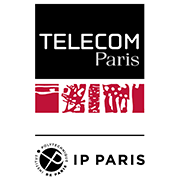</center>

<h1><center><strong><font color="chillipepper">IA 717: Sentiment Analysis Project: a peek into the conversation</font></strong></center></h1>

<center>
<h3> Project Supervisor <br/>
<email>gael.guibon@telecom-paris.fr</email>
<br/>
Year 2021-2022
</center>

------------------------

# <font color="chillipepper">**Objectives**</font>

The objective of this project is dual. First, you will learn how to deal with a specific case of sentiment analysis (emotions) considering a conversational context. Second, you will learn to manipulate and design a model considering the final task.


### <font color="chillipepper">Organization</font>
   + Data formatting
   + Data pre-treatments
   + A simple hierarchical shallow machine learning approach: 
    1. (Pre-trained Embeddings) GLoVe
    2. (Utterance Level) Average
    3. (Conversation Level) RandomForest
   + A simple hierarchical deep learning approach: 
    1. (Pre-trained Embeddings) GLoVe
    2. (Utterance Level) Average 
    3. (Conversation Level) Long-Short Term Memory
   + Tweak the model to better handle the conversational context


### <font color="chillipepper">Evaluation</font>

The project is evaluated through a presentation with a report and your completed project. If you can, try to focus on the explanation regarding your creative part of the project.

Run the following cells to install the necessary dependencies.

In [ ]:
%matplotlib inline
# import pandas to handle dataframe tables and its related operations
import pandas as pd
# import matplotlib to display charts
import matplotlib.pyplot as plt
# import several nltk tokenizers
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize import TweetTokenizer

import os, sys, getopt, gzip, json

! apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

# <font color="chillipepper">**Task Presentation**</font>

We have multiple **conversations**. 

In each **conversation**, there are **utterances** (textual content). 

Each **utterance**'s text is made of multiple **tokens** (word/punctuation/etc.).

This means our data will have the following structure:
- Dataset
  - Conversation
    - Utterance
      - Tokens

We want to **predict the emotion of each utterance**. Which means only utterances have a label:
- Dataset
  - Conversation
    - Utterance [ one of these labels: 🙂 😞 😠 😯 😐 🤮 😱 ]
      - Tokens

If we consider `u` as a representation of an utterance, we can represent a conversation as the following:

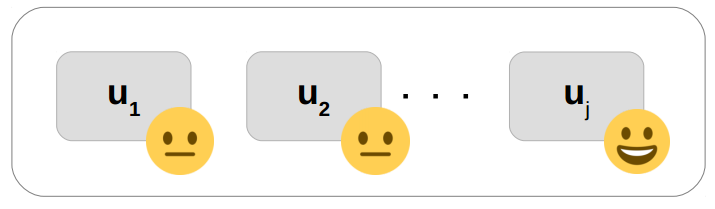

The task we want to tackle is named **Sequence Labeling**. This means we want to assign a label to each element of a sequence. In the picture above, this would mean to assign an emotion (represented here as emojis to shorten it) to each utterance. 

# <font color="chillipepper">**Data Presentation**</font>

For this project you will exploit one dataset dedicated to NLP in conversations. This dataset is named DailyDialog, made by Yanran Li, Hui Su, Xiaoyu Shen, Wenjie Li, Ziqiang Cao and Shuzi Niu and has been [published in the Proceedings of the Eighth International Joint Conference on Natural Language Processing in 2017](https://aclanthology.org/I17-1099.pdf). You can find the [dataset here](http://yanran.li/dailydialog.html)

In a humanly readable format, the data looks like this:

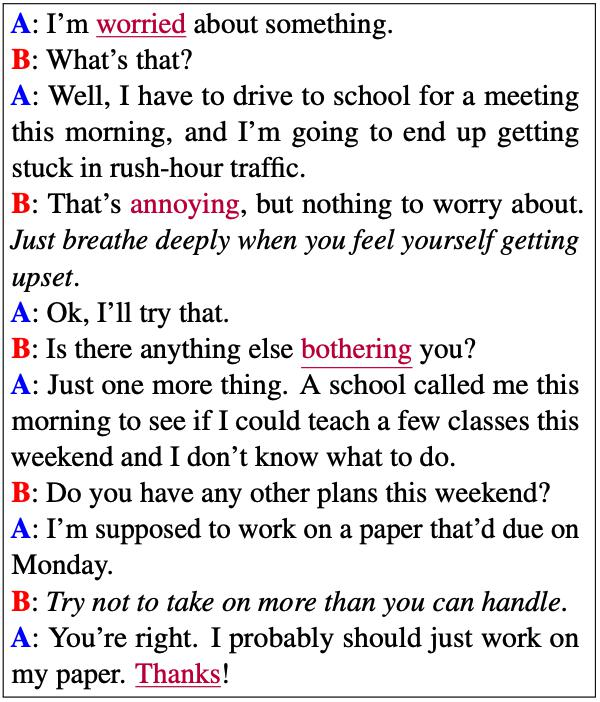

As you can see in the image, this dataset is designed as a dyadic conversation (speakers A and B). Because it is quite well formed and to ease this project, we will consider a speaker turn, also known as an **utterance**, as one single message.

Hence, "*Well, I have to drive to school for a meeting ... rush-hour traffic.*" is an **utterance**.

Let's download the dataset.

In [ ]:
! wget -O dailydialog.zip https://gitlab.com/gguibon/telecomparis-nlp-project-storage/-/raw/main/ijcnlp_dailydialog.zip?inline=false

--2022-02-12 21:12:51--  https://gitlab.com/gguibon/telecomparis-nlp-project-storage/-/raw/main/ijcnlp_dailydialog.zip?inline=false
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4475921 (4.3M) [application/zip]
Saving to: ‘dailydialog.zip’

dailydialog.zip     100%[===================>]   4.27M  12.9MB/s    in 0.3s    

2022-02-12 21:12:51 (12.9 MB/s) - ‘dailydialog.zip’ saved [4475921/4475921]



Let's unzip the dataset.

In [ ]:
! unzip dailydialog.zip

Archive:  dailydialog.zip
   creating: ijcnlp_dailydialog/
  inflating: ijcnlp_dailydialog/.DS_Store  
  inflating: ijcnlp_dailydialog/dialogues_act.txt  
  inflating: ijcnlp_dailydialog/dialogues_emotion.txt  
  inflating: ijcnlp_dailydialog/dialogues_text.txt  
  inflating: ijcnlp_dailydialog/dialogues_topic.txt  
  inflating: ijcnlp_dailydialog/readme.txt  
  inflating: ijcnlp_dailydialog/test.zip  
 extracting: ijcnlp_dailydialog/train.zip  
  inflating: ijcnlp_dailydialog/validation.zip  


In [ ]:
! unzip ijcnlp_dailydialog/train.zip
! unzip ijcnlp_dailydialog/validation.zip
! unzip ijcnlp_dailydialog/test.zip

Archive:  ijcnlp_dailydialog/train.zip
   creating: train/
  inflating: train/dialogues_act_train.txt  
  inflating: train/dialogues_emotion_train.txt  
  inflating: train/dialogues_train.txt  
Archive:  ijcnlp_dailydialog/validation.zip
   creating: validation/
  inflating: validation/dialogues_act_validation.txt  
  inflating: validation/dialogues_emotion_validation.txt  
  inflating: validation/dialogues_validation.txt  
Archive:  ijcnlp_dailydialog/test.zip
   creating: test/
  inflating: test/dialogues_act_test.txt  
  inflating: test/dialogues_emotion_test.txt  
  inflating: test/dialogues_test.txt  


As you can see, you now have the following file organization:

In [ ]:
! tree

.
├── dailydialog.zip
├── ijcnlp_dailydialog
│   ├── dialogues_act.txt
│   ├── dialogues_emotion.txt
│   ├── dialogues_text.txt
│   ├── dialogues_topic.txt
│   ├── readme.txt
│   ├── test.zip
│   ├── train.zip
│   └── validation.zip
├── sample_data
│   ├── anscombe.json
│   ├── california_housing_test.csv
│   ├── california_housing_train.csv
│   ├── mnist_test.csv
│   ├── mnist_train_small.csv
│   └── README.md
├── test
│   ├── dialogues_act_test.txt
│   ├── dialogues_emotion_test.txt
│   └── dialogues_test.txt
├── train
│   ├── dialogues_act_train.txt
│   ├── dialogues_emotion_train.txt
│   └── dialogues_train.txt
└── validation
    ├── dialogues_act_validation.txt
    ├── dialogues_emotion_validation.txt
    └── dialogues_validation.txt

5 directories, 24 files


If you take a close look, you will see that for each datasplit (train, validation, test) your information is scattered across multiple files.

For now **let's only consider the emotions in conversation**, meaning we will exploit files named `dialogues_emotion_[split].txt` and `dialogues_[split].txt`. 

Let's look inside those files:

In [ ]:
! head train/dialogues_train.txt

Say , Jim , how about going for a few beers after dinner ? __eou__ You know that is tempting but is really not good for our fitness . __eou__ What do you mean ? It will help us to relax . __eou__ Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? __eou__ I guess you are right.But what shall we do ? I don't feel like sitting at home . __eou__ I suggest a walk over to the gym where we can play singsong and meet some of our friends . __eou__ That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . __eou__ Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . __eou__ Good.Let ' s go now . __eou__ All right . __eou__
Can you do push-ups ? __eou__ Of course I can . It's a piece of cake ! Believe it or not , I can do 30 push-ups a minute . __eou__ Really ? I think that's impossible ! __eou__ You mean 30 push-ups ? __

In [ ]:
 ! head train/dialogues_train.txt

Say , Jim , how about going for a few beers after dinner ? __eou__ You know that is tempting but is really not good for our fitness . __eou__ What do you mean ? It will help us to relax . __eou__ Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? __eou__ I guess you are right.But what shall we do ? I don't feel like sitting at home . __eou__ I suggest a walk over to the gym where we can play singsong and meet some of our friends . __eou__ That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . __eou__ Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . __eou__ Good.Let ' s go now . __eou__ All right . __eou__
Can you do push-ups ? __eou__ Of course I can . It's a piece of cake ! Believe it or not , I can do 30 push-ups a minute . __eou__ Really ? I think that's impossible ! __eou__ You mean 30 push-ups ? __

In this file we have the already tokenized text, as you can see with commas `,` being surrounded by a space. However, the tokenization is not perfect as some instances prove it: `Don't worry.He is an acrobat 。 __eou__`. In this example, we would prefer to obtain `Don 't worry . He is an acrobat 。 __eou__`. But for now, we do not to dive into the tokenization correction.

**`__eou__`** means End Of Utterance. This way we can differenciate utterances from each others. 

In [ ]:
! head train/dialogues_emotion_train.txt

0 0 0 0 0 0 4 4 4 4 
0 0 6 0 0 0 
0 0 0 0 0 
0 0 0 0 
0 0 0 0 0 6 0 6 0 
0 4 0 0 0 4 0 0 0 4 
0 6 0 0 0 0 0 
0 0 0 4 4 4 4 0 4 0 0 4 4 
0 0 0 0 0 0 0 0 0 0 0 4 
0 0 0 0 0 0 


In this file, we have the emotion label for each utterance across the conversations. Each index represent one utterance's label.

Let's look at what those indices refer to.

In [ ]:
! more ijcnlp_dailydialog/readme.txt

Here are some explanations about the files:

1) dialogues_text.txt: The DailyDialog dataset which contains 11,318 transcribed
 dialogues.
2) dialogues_topic.txt: Each line in dialogues_topic.txt corresponds to the topi
c of that in dialogues_text.txt.
                        The topic number represents: {1: Ordinary Life, 2: Schoo
l Life, 3: Culture & Education,
                        4: Attitude & Emotion, 5: Relationship, 6: Tourism , 7: 
Health, 8: Work, 9: Politics, 10: Finance}
3) dialogues_act.txt: Each line in dialogues_act.txt corresponds to the dialog a
ct annotations in dialogues_text.txt.
                      The dialog act number represents: { 1: inform，2: question
, 3: directive, 4: commissive }
4) dialogues_emotion.txt: Each line in dialogues_emotion.txt corresponds to the 
emotion annotations in dialogues_text.txt.
                          The emotion number represents: { 0: no emotion, 1: ang
er, 2: disgust, 3: fear, 4: happiness, 5: sadness, 6: surprise}
5) train.zi

Now if we take the dictionary they give us, here is the label mapping variables which would be very useful afterwards.

In [ ]:
i2l = { 0: "no emotion", 1: "anger", 2: "disgust", 3: "fear", 4: "happiness", 5: "sadness", 6: "surprise" }
l2i = { v:k for k,v in i2l.items() }
print(l2i)

{'no emotion': 0, 'anger': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'sadness': 5, 'surprise': 6}


Now we have both "Index to Label" (i2l) and "Label to Index" (l2i) dictionaries.

Now let's define a global variable `args` where we will store various hyper-parameters for the task.
This is where we will store several arguments that will be used anytime we want to.

In [ ]:
args = {}

Now we need to **format the data in order to obtain files json files for each split**.

In [ ]:
i2l

{0: 'no emotion',
 1: 'anger',
 2: 'disgust',
 3: 'fear',
 4: 'happiness',
 5: 'sadness',
 6: 'surprise'}

In [ ]:
f = open("train/dialogues_train.txt", 'r')
f.read()

'Say , Jim , how about going for a few beers after dinner ? __eou__ You know that is tempting but is really not good for our fitness . __eou__ What do you mean ? It will help us to relax . __eou__ Do you really think so ? I don\'t . It will just make us fat and act silly . Remember last time ? __eou__ I guess you are right.But what shall we do ? I don\'t feel like sitting at home . __eou__ I suggest a walk over to the gym where we can play singsong and meet some of our friends . __eou__ That\'s a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . __eou__ Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . __eou__ Good.Let \' s go now . __eou__ All right . __eou__\nCan you do push-ups ? __eou__ Of course I can . It\'s a piece of cake ! Believe it or not , I can do 30 push-ups a minute . __eou__ Really ? I think that\'s impossible ! __eou__ You mean 30 push-

In [ ]:
f = open("test/dialogues_test.txt", 'r')
f.read()

'Hey man , you wanna buy some weed ? __eou__ Some what ? __eou__ Weed ! You know ? Pot , Ganja , Mary Jane some chronic ! __eou__ Oh , umm , no thanks . __eou__ I also have blow if you prefer to do a few lines . __eou__ No , I am ok , really . __eou__ Come on man ! I even got dope and acid ! Try some ! __eou__ Do you really have all of these drugs ? Where do you get them from ? __eou__ I got my connections ! Just tell me what you want and I ’ ll even give you one ounce for free . __eou__ Sounds good ! Let ’ s see , I want . __eou__ Yeah ? __eou__ I want you to put your hands behind your head ! You are under arrest ! __eou__\nThe taxi drivers are on strike again . __eou__ What for ? __eou__ They want the government to reduce the price of the gasoline . __eou__ It is really a hot potato . __eou__\nWe\'ve managed to reduce our energy consumption in our factory by about 15 per cent in the last two years . __eou__ That\'s excellent . How have you managed that ? __eou__ Mainly because we\'ve

In [ ]:
def _createDialogData(dialogue, emotion, act):
    ''' create single dialogue'''
    dialogData = list()

    # cast to list format
    utterances = dialogue.split('__eou__')[:-1]
    emotion = emotion.split()
    act = act.split()

    # Loop over the utterances
    for nbr, utt in enumerate(utterances):
    	dic = {}
    	words = utt.split()
    	dic['text'] = words
    	dic['raw'] = utt
    	dic['label'] = int(emotion[nbr])
    	dic['act'] = int(act[nbr])
    	dialogData.append(dic)
    
    return dialogData

def _getData(dialogues, emotions, acts):
    '''aggregate all dialogues'''
    data = list()
    n = len(dialogues)
    for i in range(n):
      data.append(_createDialogData(dialogues[i], emotions[i], acts[i]))
    
    return data

def _parse(in_dir, out_dir, utteranceMode, allMode):
    # COMPLETE ME! I NEED TO OPEN THE FILES AND READ THEM!yay
    # retrieve all files names from input directory
    list_of_files = list()
    for root, dirs, files in os.walk(in_dir):
      for i in files:
        list_of_files.append(os.path.join(root, i))
    out_dailydialog_dir = os.path.join(out_dir, 'dailydialog_{}.json'.format(root[2:]))
    
    # Retrieve all files informations
    print(list_of_files)
    for el in list_of_files:
      if 'emotion' in el:
        file_emotions = open(el, 'r')
      elif 'act' in el:
        file_acts = open(el, 'r')
      else:
        file_dialogues = open(el, 'r')
    
    dialogues = [line.strip() for line in file_dialogues]  
    emotions = [line.strip() for line in file_emotions]
    acts = [line.strip() for line in file_acts]
    
    data = _getData(dialogues, emotions, acts)

    with open(out_dailydialog_dir, 'w') as f:
        jsonData = [ json.dumps(d) for d in data]
        f.write('\n'.join(jsonData))


Let's see the current higher level directory content

In [ ]:
! ls .

dailydialog.zip  ijcnlp_dailydialog  sample_data  test	train  validation


In [ ]:
for split in ["train", "validation", "test"]:
    _parse("./%s" % (split), ".", False, False)

['./train/dialogues_train.txt', './train/dialogues_emotion_train.txt', './train/dialogues_act_train.txt']
['./validation/dialogues_act_validation.txt', './validation/dialogues_validation.txt', './validation/dialogues_emotion_validation.txt']
['./test/dialogues_act_test.txt', './test/dialogues_test.txt', './test/dialogues_emotion_test.txt']


Now we have one file per split with all the information gathered inside to make it easier to process.

Each line is a conversation, a list of utterances (json objects) with the following keys: "text", "raw", "label", "act". For the "text" field, we do not need the case.

In [ ]:
! head dailydialog_train.json

[{"text": ["Say", ",", "Jim", ",", "how", "about", "going", "for", "a", "few", "beers", "after", "dinner", "?"], "raw": "Say , Jim , how about going for a few beers after dinner ? ", "label": 0, "act": 3}, {"text": ["You", "know", "that", "is", "tempting", "but", "is", "really", "not", "good", "for", "our", "fitness", "."], "raw": " You know that is tempting but is really not good for our fitness . ", "label": 0, "act": 4}, {"text": ["What", "do", "you", "mean", "?", "It", "will", "help", "us", "to", "relax", "."], "raw": " What do you mean ? It will help us to relax . ", "label": 0, "act": 2}, {"text": ["Do", "you", "really", "think", "so", "?", "I", "don't", ".", "It", "will", "just", "make", "us", "fat", "and", "act", "silly", ".", "Remember", "last", "time", "?"], "raw": " Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? ", "label": 0, "act": 2}, {"text": ["I", "guess", "you", "are", "right.But", "what", "shall", "we", "do", "?", "I",

In [ ]:
! head dailydialog_test.json

[{"text": ["Hey", "man", ",", "you", "wanna", "buy", "some", "weed", "?"], "raw": "Hey man , you wanna buy some weed ? ", "label": 0, "act": 3}, {"text": ["Some", "what", "?"], "raw": " Some what ? ", "label": 6, "act": 2}, {"text": ["Weed", "!", "You", "know", "?", "Pot", ",", "Ganja", ",", "Mary", "Jane", "some", "chronic", "!"], "raw": " Weed ! You know ? Pot , Ganja , Mary Jane some chronic ! ", "label": 0, "act": 3}, {"text": ["Oh", ",", "umm", ",", "no", "thanks", "."], "raw": " Oh , umm , no thanks . ", "label": 0, "act": 4}, {"text": ["I", "also", "have", "blow", "if", "you", "prefer", "to", "do", "a", "few", "lines", "."], "raw": " I also have blow if you prefer to do a few lines . ", "label": 0, "act": 3}, {"text": ["No", ",", "I", "am", "ok", ",", "really", "."], "raw": " No , I am ok , really . ", "label": 0, "act": 4}, {"text": ["Come", "on", "man", "!", "I", "even", "got", "dope", "and", "acid", "!", "Try", "some", "!"], "raw": " Come on man ! I even got dope and acid ! T

This is not really convenient, what we want at the end is a global structure (dict) with labels, texts, etc. where the order is strict. 

Now let's first change the representation in order to merge texts together.



In [ ]:
from tqdm.notebook import trange, tqdm
from termcolor import colored
from nltk.tokenize import TweetTokenizer
import numpy as np
from collections import OrderedDict, Counter, defaultdict

def creaDailyDialogSeq():
  splits = {'train':'dailydialog_train.json', 'test':'dailydialog_test.json', 'val': 'dailydialog_validation.json'}
  splits_emotionflows_fp = { k: os.path.join( os.path.dirname(v), 'dailydialog_{}_emotionflow.json'.format(k) ) for k,v in splits.items() }
  txt2l = { 'no emotion': 0, 'anger': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'sadness': 5, 'surprise': 6 }
  l2txt = { v:k for k, v in txt2l.items() } 
  emotionSet = list(set(list(txt2l.keys())))
  
  emotionFlows = {'train':[],'test':[],'val':[]}

  def getEmotionFlows(row, split):
    row = json.loads(row)
    
    emotionFlow = [ l2txt[r['label']] for r in row ]
    emotionFlows[split].append(emotionFlow)

  for k,v in tqdm(splits.items()):
    for row in tqdm( open(v, 'r').read().split('\n'), desc=colored(v, 'cyan') ) :
      getEmotionFlows(row, k)

  seq_lengths = np.array([ len(x) for x in emotionFlows['train'] ] )
  #  seq_size = np.percentile( seq_lengths, 90)
  #  seq_size = max(seq_lengths)
  seq_size = 12 # we put an arbitrary max length
  print(colored('seq_size', 'yellow'), seq_size, '75%:', np.percentile(seq_lengths, 75), 'max:', max(seq_lengths))
  
  def tokenize_seq(chat):
    tk = TweetTokenizer()
    chat_text = tk.tokenize(chat['raw'])
    chat['text'] = chat_text
    
    return chat
  
  def _trimpad(size, row, pad=True, trim=True):
    ''' trim and padding (with <pad>) '''
    # Reshapping all dialogues with same lengh (12 utterances)   
    n = len(row['texts'])
    
    if n < seq_size:
      [row['texts'].insert(0, ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>']) for _ in range(seq_size - n)]
      [row['labels'].insert(0, 0) for _ in range(seq_size - n)]
    elif n > seq_size:
      for j in range(n - seq_size):
        del row['texts'][0]
        del row['labels'][0]
  
    return row
  
  dataSplits = {'train':[], 'test': [], 'val':[]}
  # loop over train, test and validation sets
  for split in dataSplits.keys():
    for i, data in tqdm( enumerate( [ json.loads(line) for line in open(splits[split], 'r').read().split('\n') ]  ), desc=colored('formatting sequence '+split, 'cyan'), total=len(emotionFlows[split]) ):
      data = [ tokenize_seq(chat) for chat in data ]
      entry = {'texts': [ x['text'] for x in data], 'labels': [ x['label'] for x in data], 'split': split}
      entry = _trimpad(seq_size, entry)
      dataSplits[split].append(entry)
  labels_train = Counter([ label for line in dataSplits['train'] for label in line['labels'] ])
  labels_val = Counter([ label for line in dataSplits['val'] for label in line['labels'] ])
  labels_test = Counter([ label for line in dataSplits['test'] for label in line['labels'] ])
  print(colored('labels balance', 'yellow'), labels_train, len(labels_train.keys()), labels_val, len(labels_val.keys()), labels_test, len(labels_test.keys()))

  records = dataSplits['train'] + dataSplits['val'] + dataSplits['test']
  jsonLines = [json.dumps(line) for line  in tqdm(records)]
  with open('dailydialog_conv{}seq_splits.json'.format(str(int(seq_size))), 'w') as f: f.write('\n'.join(jsonLines))

Let's run our function.

In [ ]:
creaDailyDialogSeq()

  0%|          | 0/3 [00:00<?, ?it/s]

dailydialog_train.json:   0%|          | 0/11118 [00:00<?, ?it/s]

dailydialog_test.json:   0%|          | 0/1000 [00:00<?, ?it/s]

dailydialog_validation.json:   0%|          | 0/1000 [00:00<?, ?it/s]

seq_size 12 75%: 10.0 max: 35


formatting sequence train:   0%|          | 0/11118 [00:00<?, ?it/s]

formatting sequence test:   0%|          | 0/1000 [00:00<?, ?it/s]

formatting sequence val:   0%|          | 0/1000 [00:00<?, ?it/s]

labels balance Counter({0: 118938, 4: 10831, 6: 1502, 5: 926, 1: 791, 2: 297, 3: 131}) 7 Counter({0: 11061, 4: 679, 6: 99, 5: 76, 1: 71, 3: 11, 2: 3}) 7 Counter({0: 10628, 4: 991, 1: 114, 6: 111, 5: 96, 2: 43, 3: 17}) 7


  0%|          | 0/13118 [00:00<?, ?it/s]

# **<font color="chillipepper">Prepare the dataset as conversations all_in_one</font>**

In [ ]:
def _load_json_seq(path, args):
    '''
        load our json format data file
        @param path: str, path to the data file
        @return data: list of examples
    '''
    label = {}
    text_len = []
    with open(path, 'r', errors='ignore') as f:
        data = []
        for i, line in enumerate(f):
            row = json.loads(line)

            for l in row['labels']:
                if int(l) not in label: label[int(l)] = 1
                else: label[int(l)] += 1

            item = {
                'id': i+1,
                'label': [int(r) for r in row['labels'] ],
                'text': [ r[-args['maxtokens']:] for r in row['texts'] ]
            }

            if 'split' in row: item['split'] = row['split']

            text_len.append(len(row['texts']))

            data.append(item)

        print('Class balance (load_json_seq):')

        print(label)

        print('Avg len: {}'.format(sum(text_len) / (len(text_len))))
        print('Max len: {}'.format(max(text_len)))

        return data

In [ ]:
all_data = _load_json_seq("dailydialog_conv12seq_splits.json", {'maxtokens': 30})

Class balance (load_json_seq):
{0: 140627, 4: 12501, 6: 1712, 3: 159, 2: 343, 5: 1098, 1: 976}
Avg len: 12.0
Max len: 12


In [ ]:
print(all_data[0])

{'id': 1, 'label': [0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4], 'text': [['<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['Say', ',', 'Jim', ',', 'how', 'about', 'going', 'for', 'a', 'few', 'beers', 'after', 'dinner', '?'], ['You', 'know', 'that', 'is', 'tempting', 'but', 'is', 'really', 'not', 'good', 'for', 'our', 'fitness', '.'], ['What', 'do', 'you', 'mean', '?', 'It', 'will', 'help', 'us', 'to', 'relax', '.'], ['Do', 'you', 'really', 'think', 'so', '?', 'I', "don't", '.', 'It', 'will', 'just', 'make', 'us', 'fat', 'and', 'act', 'silly', '.', 'Remember', 'last', 'time', '?'], ['I', 'guess', 'you', 'are', 'right.But', 'what', 'shall', 'we', 'do', '?', 'I', "don't", 'feel', 'like', 'sitting', 'at', 'home', '.'], ['I', 'suggest', 'a', 'walk', 'over', 'to', 'the', 'gym', 'where', 'we', 'can', 'play', 'singsong', 'and', 'meet', 'some', 'of', 'our', 'friends', '.'], ["That's", 'a', 'good', 'idea', '.', 'I', 'hear', 'Mary', 'and', 'Sally', 'often', '

## <font color="chillipepper">Stemming and Lemmatization Recap'</font>

We call stemming the operation consisting into retrieving the smallest common group of characters for multiple words' occurrences.

```
Stem: Mang
Words Occurrences:
- mange
- mangions
- mangé
```

We call lemmatizing the operation of taking the original, standard, common word between multiple flectional forms of the word.

```
Lemma: Manger
Flectional Forms:
- mange
- mangions
- mangé
```

This clearly means we need a lexicon for lemmatization.

**Applying a stemming** on the first two conversations and save it in a **new variable**. 

Using NLTK for this: https://www.nltk.org/api/nltk.stem.html

In [ ]:
import nltk
from nltk.stem.lancaster import LancasterStemmer

In [ ]:
conv = all_data[0]['text'] + all_data[1]['text']
lexicon = list()
st = LancasterStemmer()

for utt in conv:
  lex = list()
  for el in utt:
    lex.append(st.stem(el))
  lexicon.append(lex)

print(lexicon)

[['<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['say', ',', 'jim', ',', 'how', 'about', 'going', 'for', 'a', 'few', 'beer', 'aft', 'din', '?'], ['you', 'know', 'that', 'is', 'tempt', 'but', 'is', 'real', 'not', 'good', 'for', 'our', 'fit', '.'], ['what', 'do', 'you', 'mean', '?', 'it', 'wil', 'help', 'us', 'to', 'relax', '.'], ['do', 'you', 'real', 'think', 'so', '?', 'i', "don't", '.', 'it', 'wil', 'just', 'mak', 'us', 'fat', 'and', 'act', 'sil', '.', 'rememb', 'last', 'tim', '?'], ['i', 'guess', 'you', 'ar', 'right.but', 'what', 'shal', 'we', 'do', '?', 'i', "don't", 'feel', 'lik', 'sit', 'at', 'hom', '.'], ['i', 'suggest', 'a', 'walk', 'ov', 'to', 'the', 'gym', 'wher', 'we', 'can', 'play', 'singsong', 'and', 'meet', 'som', 'of', 'our', 'friend', '.'], ["that's", 'a', 'good', 'ide', '.', 'i', 'hear', 'mary', 'and', 'sal', 'oft', 'go', 'ther', 'to', 'play', 'pingpong.perhaps', 'we', 'can', 'mak', 'a', 'foursom', 'with', 'them', '.'], ['s

For this project we will consider neither stemming nor lemmatizing as we will use **vectors mapped to flectional forms**.

# <font color="chillipepper">**Word Embeddings Mapping**</font>

In this project we will use pre-trained [GloVe word embeddings](https://nlp.stanford.edu/projects/glove/). Both for the shallow machine learning approach and the deep learning approach. However, more steps will be necessary for the latter.

GloVe embeddings were created by [Stanford NLP in 2014](https://nlp.stanford.edu/pubs/glove.pdf). They are essentially a set of words for each there is a vector reprensenting information of this word. This set of (word,vector) couples can be used to do superlative comparisons such as this one:

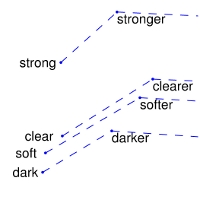


For now, we will use the [Gensim API ](https://radimrehurek.com/gensim/)to easily [obtain pretrained embeddings](https://radimrehurek.com/gensim/downloader.html).

In [ ]:
import gensim.downloader as api
# loading can fail, just run it again if it is the case
pretrained_ebd_path = api.load('glove-wiki-gigaword-300', return_path=True)
print("embedding path is:", pretrained_ebd_path)
pretrained_ebd = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded
embedding path is: /root/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz


Let's look at the vector representing the word "telecom".

In [ ]:
pretrained_ebd['telecom']

array([-1.4492e-01, -2.2374e-01, -5.8602e-01, -1.2850e-03,  4.2280e-01,
       -1.4507e-01, -5.4870e-01,  3.7074e-01, -2.7480e-01, -1.1219e+00,
        3.9556e-01, -5.4618e-02,  1.1784e-01, -2.8727e-01,  6.9186e-01,
       -2.0109e-02, -1.2065e+00, -8.3074e-02, -4.2417e-01, -4.2255e-01,
       -2.5186e-01,  3.7424e-02,  2.5989e-01,  3.1142e-01, -4.2296e-01,
       -1.0821e+00, -4.2718e-02,  1.8130e-01,  2.8606e-01,  2.5501e-02,
       -2.8400e-01, -5.0520e-01, -3.7523e-01,  2.8327e-01, -8.4046e-01,
        9.9890e-02,  2.9666e-01, -2.6858e-01,  3.6917e-01, -1.0043e-01,
        5.4073e-03, -2.1548e-01, -3.0655e-01,  6.4237e-01,  1.4483e-01,
       -4.8807e-01, -7.3378e-01, -1.4026e-01,  8.0277e-02, -2.2468e-01,
        1.2824e-01, -2.1287e-01, -1.7251e-01,  2.9638e-02,  4.6546e-01,
        3.7941e-01, -1.0850e-01,  6.2264e-01,  2.1785e-01, -3.5520e-01,
        8.4330e-02,  6.1435e-01, -6.7041e-01, -2.3779e-01, -3.3777e-01,
        2.1876e-02, -3.0871e-01, -3.4865e-01, -4.3211e-01, -3.98

Let's look at the embedding size.

In [ ]:
pretrained_ebd['telecom'].shape

(300,)

Let's look at the most similar vectors to "telecom"'s vector.

In [ ]:
pretrained_ebd.most_similar("telecom")

[('telecommunications', 0.7571609020233154),
 ('telecoms', 0.7018751502037048),
 ('telecommunication', 0.6589325666427612),
 ('alcatel', 0.5912817716598511),
 ('vodafone', 0.576548159122467),
 ('telekom', 0.5742987394332886),
 ('wireless', 0.536865234375),
 ('telefonica', 0.5352122783660889),
 ('lucent', 0.5186995267868042),
 ('telstra', 0.5142642259597778)]

Change the whole textual data splits into numpy arrays of vectors.

In [ ]:
train_data = [d for d in all_data if d['split'] == 'train']
val_data = [d for d in all_data if d['split'] == 'val']
test_data = [d for d in all_data if d['split'] == 'test']

In [ ]:
def text_to_vectors_average_utterance(data, ebd, dim=300):
  pad_vector = np.ones(dim)
  unk_vector = np.zeros(dim)
  data_vectors = list()
  for d in tqdm(data):
    conversation_vectors = list()
    for utterance in d['text']:
      utterance_vectors = list()
      for w in utterance:
        try:
          utterance_vectors.append(ebd[w])
        except:
          utterance_vectors.append(unk_vector)
      avg_utterance_vector = np.mean(np.array(utterance_vectors), axis=0)
      conversation_vectors.append(avg_utterance_vector.tolist())
    data_vectors.append(conversation_vectors)
  return np.array(data_vectors)

In [ ]:
X_train = text_to_vectors_average_utterance(train_data, pretrained_ebd)
y_train = np.array([ d['label'] for d in train_data ])

X_test = text_to_vectors_average_utterance(test_data, pretrained_ebd)
y_test = np.array([ d['label'] for d in test_data ])

  0%|          | 0/11118 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:01<?, ?it/s]

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11118, 12, 300)
(11118, 12)
(1000, 12, 300)
(1000, 12)


In [ ]:
X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[-1])

In [ ]:
print('flatten shapes')
print(X_train.shape)
print(X_test.shape)

flatten shapes
(11118, 3600)
(1000, 3600)


# <font color="chillipepper">**Good Old Fashion AI (GOFAI) Models**</font>

This barbaric term indicates shallow models, or, to put it simply, everything that is Machine Learning but not Deep Learning. Keep in mind, Deep Learning is a sub-part of Machine Learning.

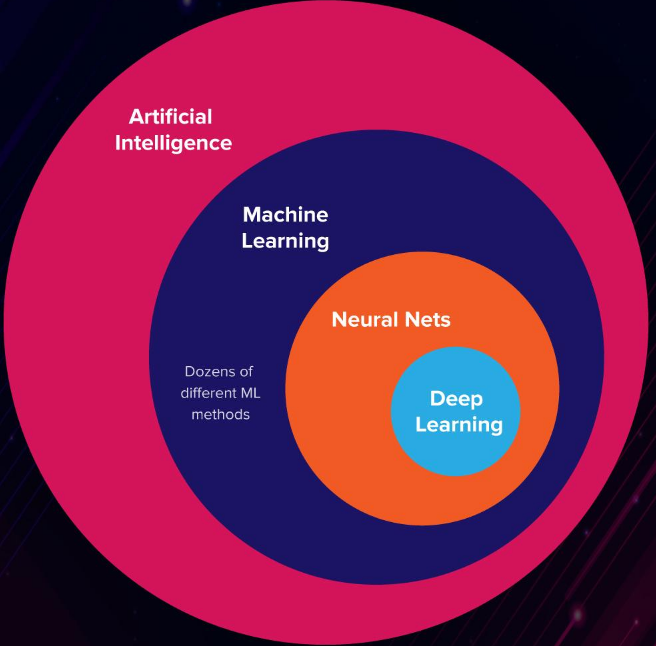

Now we need to use a Machine Learning algorithm: the **Logistic Regression**.

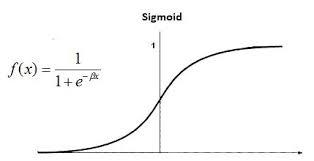

From https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/

We are going to train the classifier on the train set and predict on the test set.

The logistic regression is made for binary classification. Hence we use the multiouput wrapper to enable multiple instance for each output (y is a 2D array).

In [ ]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Fit the LogisticRegression using the MultiOutputClassifier wrapper
clf = MultiOutputClassifier(LogisticRegression(n_jobs=-1))
clf.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(n_jobs=-1))

In [ ]:
# Predict the labels and create
y_pred = clf.predict(X_test)

In [ ]:
print(y_test, y_test.shape)

[[0 6 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 6 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 4 ... 0 4 4]] (1000, 12)


In [ ]:
print(y_pred, y_pred.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 4 4 ... 4 4 4]] (1000, 12)


Predictions are 2D arrays. We need to put it in a flat representation (1D) to use the metric computation functions easily.

In [ ]:
y_pred_flat = y_pred.flatten()
y_test_flat = y_test.flatten()
print(y_pred_flat.shape)
print(y_test_flat.shape)

(12000,)
(12000,)


In [ ]:
names = ['no emotion', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
print(classification_report(y_test_flat, y_pred_flat, target_names=names))

              precision    recall  f1-score   support

  no emotion       0.92      0.96      0.94     10628
       anger       0.42      0.14      0.21       114
     disgust       0.62      0.12      0.20        43
        fear       0.00      0.00      0.00        17
   happiness       0.52      0.39      0.45       991
     sadness       0.43      0.10      0.17        96
    surprise       0.30      0.14      0.19       111

    accuracy                           0.89     12000
   macro avg       0.46      0.27      0.31     12000
weighted avg       0.87      0.89      0.87     12000



In [ ]:
y_pred[3]

array([0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0])

Let's see the confusion matrix! This is the core part to dive into model's performance indications.

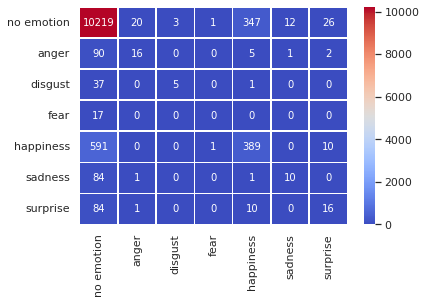

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(y_test_flat, y_pred_flat)
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

# <font color="chillipepper">**Prepare the data as numerical inputs**</font>

Why prepare the data this way? So we control everything and it's easily usable for both Shallow and Deep models.

In the following cell, there is a utility function designed to delete elements by their index, this allows an easy deletion even with the format we have.

In [ ]:
def _del_by_idx(array_list, idx, axis):
    '''
        Delete the specified index for each array in the array_lists

        @params: array_list: list of np arrays
        @params: idx: list of int
        @params: axis: int

        @return: res: tuple of pruned np arrays
    '''
    if type(array_list) is not list:
        array_list = [array_list]

    # performs operations in place
    for i, array in enumerate(array_list):
        array_list[i] = np.delete(array, idx, axis)

    if len(array_list) == 1:
        return array_list[0]
    else:
        return array_list


[Torch Text](https://pytorch.org/text/stable/index.html) is really useful to deal with batches by using already made functions.

Let's first use [TorchText vocab](https://pytorch.org/text/stable/vocab.html) functions to download pre-trained [GloVe word embeddings](https://nlp.stanford.edu/projects/glove/).

GloVe embeddings were created by [Stanford NLP in 2014](https://nlp.stanford.edu/pubs/glove.pdf). They are essentially a set of words for each there is a vector reprensenting information of this word. This set of (word,vector) couples can be used to do superlative comparisons such as this one:

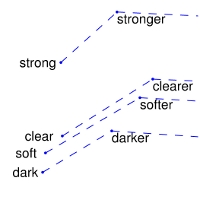

In [ ]:
# glove through torch text (it will download it only once)
from torchtext.vocab import GloVe, vocab
# Wikipedia small model
#glove_vectors = GloVe(name="6B", dim='50')
# Big model with embedding size 300. Trained on Common Crawls
glove_vectors = GloVe(name='840B', dim='300')

.vector_cache/glove.840B.300d.zip: 2.18GB [06:50, 5.30MB/s]                            
100%|█████████▉| 2196016/2196017 [04:26<00:00, 8251.92it/s]


In [ ]:
glove_vectors.vectors

tensor([[-0.0828,  0.6720, -0.1499,  ..., -0.1918, -0.3785, -0.0659],
        [ 0.0120,  0.2075, -0.1258,  ...,  0.1387, -0.3605, -0.0350],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.7344, -0.3364,  0.2692,  ...,  0.6372, -0.1391, -0.1647],
        [ 0.2121, -0.9946,  1.1782,  ...,  0.9343, -0.9329, -0.5148],
        [-0.0797, -0.2290,  0.8037,  ..., -0.0836,  0.4853, -0.7313]])

Let's see what the model looks like

In [ ]:
glove_vectors.stoi

{',': 0,
 '.': 1,
 'the': 2,
 'and': 3,
 'to': 4,
 'of': 5,
 'a': 6,
 'in': 7,
 '"': 8,
 ':': 9,
 'is': 10,
 'for': 11,
 'I': 12,
 ')': 13,
 '(': 14,
 'that': 15,
 '-': 16,
 'on': 17,
 'you': 18,
 'with': 19,
 "'s": 20,
 'it': 21,
 'The': 22,
 'are': 23,
 'by': 24,
 'at': 25,
 'be': 26,
 'this': 27,
 'as': 28,
 'from': 29,
 'was': 30,
 'have': 31,
 'or': 32,
 '...': 33,
 'your': 34,
 'not': 35,
 '!': 36,
 '?': 37,
 'will': 38,
 'an': 39,
 "n't": 40,
 'can': 41,
 'but': 42,
 'all': 43,
 'my': 44,
 'has': 45,
 '|': 46,
 'do': 47,
 'we': 48,
 'they': 49,
 'more': 50,
 'one': 51,
 'about': 52,
 'he': 53,
 ';': 54,
 "'": 55,
 'out': 56,
 '$': 57,
 'their': 58,
 'so': 59,
 'his': 60,
 'up': 61,
 'It': 62,
 '&': 63,
 'like': 64,
 '/': 65,
 '1': 66,
 'which': 67,
 'if': 68,
 'would': 69,
 'our': 70,
 '[': 71,
 ']': 72,
 'me': 73,
 'who': 74,
 'just': 75,
 'This': 76,
 'time': 77,
 'what': 78,
 'A': 79,
 '2': 80,
 'had': 81,
 'when': 82,
 'there': 83,
 'been': 84,
 'some': 85,
 'get': 86,
 'wer

Words and associated indices. Seems like what we need to numericalize the text data!

With `glove_vocab.insert_token("<unk>",unk_index)` we add the unknown token in the vocabulary. We do the same for the padding token.

In [ ]:
import torch
import torch.nn as nn
# freeze to False if you want to make the vectors trainable
embedding_layer = torch.nn.Embedding.from_pretrained(glove_vectors.vectors,freeze=True)

In [ ]:
from torchtext.vocab import GloVe, vocab

glove_vocab = vocab(glove_vectors.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
glove_vocab.insert_token("<unk>",unk_index)
glove_vocab.insert_token("<pad>", pad_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
glove_vocab.set_default_index(unk_index)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([2196018, 300])

In [ ]:
len(all_data)

13118

In [ ]:
all_data[0]

{'id': 1,
 'label': [0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4],
 'split': 'train',
 'text': [['<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
  ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
  ['Say',
   ',',
   'Jim',
   ',',
   'how',
   'about',
   'going',
   'for',
   'a',
   'few',
   'beers',
   'after',
   'dinner',
   '?'],
  ['You',
   'know',
   'that',
   'is',
   'tempting',
   'but',
   'is',
   'really',
   'not',
   'good',
   'for',
   'our',
   'fitness',
   '.'],
  ['What',
   'do',
   'you',
   'mean',
   '?',
   'It',
   'will',
   'help',
   'us',
   'to',
   'relax',
   '.'],
  ['Do',
   'you',
   'really',
   'think',
   'so',
   '?',
   'I',
   "don't",
   '.',
   'It',
   'will',
   'just',
   'make',
   'us',
   'fat',
   'and',
   'act',
   'silly',
   '.',
   'Remember',
   'last',
   'time',
   '?'],
  ['I',
   'guess',
   'you',
   'are',
   'right.But',
   'what',
   'shall',
   'we',
   'do',
   '?',
   'I',
   "don't",
   'feel',
   'like',
   'sitting',
   'a

In [ ]:
all_data[0].keys()

dict_keys(['id', 'label', 'text', 'split'])

In [ ]:
glove_vocab.get_itos()[0]

'<unk>'

In [ ]:
glove_vectors.stoi

{',': 0,
 '.': 1,
 'the': 2,
 'and': 3,
 'to': 4,
 'of': 5,
 'a': 6,
 'in': 7,
 '"': 8,
 ':': 9,
 'is': 10,
 'for': 11,
 'I': 12,
 ')': 13,
 '(': 14,
 'that': 15,
 '-': 16,
 'on': 17,
 'you': 18,
 'with': 19,
 "'s": 20,
 'it': 21,
 'The': 22,
 'are': 23,
 'by': 24,
 'at': 25,
 'be': 26,
 'this': 27,
 'as': 28,
 'from': 29,
 'was': 30,
 'have': 31,
 'or': 32,
 '...': 33,
 'your': 34,
 'not': 35,
 '!': 36,
 '?': 37,
 'will': 38,
 'an': 39,
 "n't": 40,
 'can': 41,
 'but': 42,
 'all': 43,
 'my': 44,
 'has': 45,
 '|': 46,
 'do': 47,
 'we': 48,
 'they': 49,
 'more': 50,
 'one': 51,
 'about': 52,
 'he': 53,
 ';': 54,
 "'": 55,
 'out': 56,
 '$': 57,
 'their': 58,
 'so': 59,
 'his': 60,
 'up': 61,
 'It': 62,
 '&': 63,
 'like': 64,
 '/': 65,
 '1': 66,
 'which': 67,
 'if': 68,
 'would': 69,
 'our': 70,
 '[': 71,
 ']': 72,
 'me': 73,
 'who': 74,
 'just': 75,
 'This': 76,
 'time': 77,
 'what': 78,
 'A': 79,
 '2': 80,
 'had': 81,
 'when': 82,
 'there': 83,
 'been': 84,
 'some': 85,
 'get': 86,
 'wer

In [ ]:
glove_vocab.get_itos()

['<unk>',
 '<pad>',
 '.',
 'the',
 'and',
 'to',
 'of',
 'a',
 'in',
 '"',
 ':',
 'is',
 'for',
 'I',
 ')',
 '(',
 'that',
 '-',
 'on',
 'you',
 'with',
 "'s",
 'it',
 'The',
 'are',
 'by',
 'at',
 'be',
 'this',
 'as',
 'from',
 'was',
 'have',
 'or',
 '...',
 'your',
 'not',
 '!',
 '?',
 'will',
 'an',
 "n't",
 'can',
 'but',
 'all',
 'my',
 'has',
 '|',
 'do',
 'we',
 'they',
 'more',
 'one',
 'about',
 'he',
 ';',
 "'",
 'out',
 '$',
 'their',
 'so',
 'his',
 'up',
 'It',
 '&',
 'like',
 '/',
 '1',
 'which',
 'if',
 'would',
 'our',
 '[',
 ']',
 'me',
 'who',
 'just',
 'This',
 'time',
 'what',
 'A',
 '2',
 'had',
 'when',
 'there',
 'been',
 'some',
 'get',
 'were',
 'other',
 'also',
 'In',
 'her',
 'them',
 'You',
 'new',
 'We',
 'no',
 'any',
 '>',
 'people',
 'than',
 'into',
 'only',
 '3',
 'how',
 'its',
 'first',
 'said',
 'i',
 'If',
 'over',
 'make',
 'good',
 'know',
 'very',
 '%',
 'am',
 'now',
 'see',
 'may',
 'she',
 'could',
 'most',
 'then',
 "'m",
 'use',
 'these'

In [ ]:
glove_vectors.vectors.size()

torch.Size([2196017, 300])

Now we need to convert the data into a dictionary of numpy arrays. This is very useful afterwards for speed.

In [ ]:
glove_vocab.get_itos()[5141]

'Satellite'

In [ ]:
glove_vectors.stoi

{',': 0,
 '.': 1,
 'the': 2,
 'and': 3,
 'to': 4,
 'of': 5,
 'a': 6,
 'in': 7,
 '"': 8,
 ':': 9,
 'is': 10,
 'for': 11,
 'I': 12,
 ')': 13,
 '(': 14,
 'that': 15,
 '-': 16,
 'on': 17,
 'you': 18,
 'with': 19,
 "'s": 20,
 'it': 21,
 'The': 22,
 'are': 23,
 'by': 24,
 'at': 25,
 'be': 26,
 'this': 27,
 'as': 28,
 'from': 29,
 'was': 30,
 'have': 31,
 'or': 32,
 '...': 33,
 'your': 34,
 'not': 35,
 '!': 36,
 '?': 37,
 'will': 38,
 'an': 39,
 "n't": 40,
 'can': 41,
 'but': 42,
 'all': 43,
 'my': 44,
 'has': 45,
 '|': 46,
 'do': 47,
 'we': 48,
 'they': 49,
 'more': 50,
 'one': 51,
 'about': 52,
 'he': 53,
 ';': 54,
 "'": 55,
 'out': 56,
 '$': 57,
 'their': 58,
 'so': 59,
 'his': 60,
 'up': 61,
 'It': 62,
 '&': 63,
 'like': 64,
 '/': 65,
 '1': 66,
 'which': 67,
 'if': 68,
 'would': 69,
 'our': 70,
 '[': 71,
 ']': 72,
 'me': 73,
 'who': 74,
 'just': 75,
 'This': 76,
 'time': 77,
 'what': 78,
 'A': 79,
 '2': 80,
 'had': 81,
 'when': 82,
 'there': 83,
 'been': 84,
 'some': 85,
 'get': 86,
 'wer

In [ ]:
def _data_to_nparray(data, vocab_stoi, vectors, args):
    '''
        Convert the data into a dictionary of np arrays for speed.
    '''
    doc_label = np.array([x['label'] for x in data], dtype=np.int64)
    raw = np.array([e['text'] for e in data], dtype=object)
    
    # compute the max text length
    len_list = list() # containing all utterances lengths
    for el in raw:
      for i in el:
        len_list.append(len(i))
    
    max_len = max(len_list)

    # initialize the big numpy array by <pad>
    idx_words = np.array(['<pad>' for i in range(max_len)])  # np array in which we stack the words casted in indices
    
    # convert each token to its corresponding id
    text = list()
    for dial in raw:
      dial_list = list()
      for utt in dial:
        utt_words = list()
        utt_words = [vocab_stoi[word.lower()] if word.lower() in vocab_stoi else vocab_stoi['<unk>'] for word in utt]
        if len(utt_words) < 30:
          [utt_words.append(1) for i in range(30 - len(utt_words))]
        dial_list.append(np.asarray(utt_words))
      text.append(np.asarray(dial_list))
      
    # filter out document with only unk and pad
    del_idx = []
    for i in range(len(text)):
      if np.max(text[i]) < 2:
        del_idx.append(i)

    vocab_size = vectors.size()[0]

    ## Curation for padding (string instead of list of list)
    raw = [ ["<pad>" if m == ["<pad>", "<pad>", "<pad>", "<pad>", "<pad>"] else m for m in c ] for c in raw ]
    
    # use _del_by_idx to filter out some elements from del_idx
    
    ids = np.array([])
    for d in data:
      ids = np.append(ids, d['id'])

    text_len = list()
  
    for el in data:
      [text_len.append(len(i)) for i in el['text']]
    
    new_data = {
        'ids': ids,
        'text': np.asarray(text),
        'text_len': np.asarray(text_len),
        'label': doc_label,
        'raw': raw,
        'vocab_size': vocab_size,
    }

    return new_data

In [ ]:
train_data = _data_to_nparray([d for d in all_data if d['split'] == 'train'], glove_vocab.get_stoi(), glove_vectors.vectors, {})
val_data = _data_to_nparray([d for d in all_data if d['split'] == 'val'], glove_vocab.get_stoi(), glove_vectors.vectors, {})
test_data = _data_to_nparray([d for d in all_data if d['split'] == 'test'], glove_vocab.get_stoi(), glove_vectors.vectors, {})

In [ ]:
train_data['text'].shape

(11118, 12, 30)

In [ ]:
train_data['text']

array([[[      1,       1,       1, ...,       1,       1,       1],
        [      1,       1,       1, ...,       1,       1,       1],
        [    217,       0,   26365, ...,       1,       1,       1],
        ...,
        [   1459,     159,       5, ...,       1,       1,       1],
        [      0,      56,     270, ...,       1,       1,       1],
        [     44,     170,       2, ...,       1,       1,       1]],

       [[      1,       1,       1, ...,       1,       1,       1],
        [      1,       1,       1, ...,       1,       1,       1],
        [      1,       1,       1, ...,       1,       1,       1],
        ...,
        [     19,     616,     308, ...,       1,       1,       1],
        [   2611,      37,       1, ...,       1,       1,       1],
        [ 727539,     427,       2, ...,       1,       1,       1]],

       [[      1,       1,       1, ...,       1,       1,       1],
        [      1,       1,       1, ...,       1,       1,       1],
    

In [ ]:
[[glove_vocab.get_itos()[i] for i in seq] for seq in train_data['text'][0]]

[['<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['say',
  '<unk>',
  'jim',
  '<unk>',
  'how',
  'about',
  'going',
  'for',
  'a',
  'few',
  'beers',
  'after',
  'dinner',
  '?',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['you',
  'know',
  'th

# <font color="chillipepper">**Dataset Class**</font>

Now that the data is numericalized, we need to create batches. In Torch, batches are usually made using two components: 
- a Dataset, wich will drive the data handling of each element
- a DataLoader, which will use the above Dataset to create batches, share it accross multiple processes, etc.

The crucial part is the dataset, but in our case, the data is already well formed, we will create a custom Dataset to handle our dictionaries that we want to send to the model.

In [ ]:
def batch_to_cuda(data, cuda, exclude_keys=[]):
    '''
        Move all values (tensors) to cuda if specified
    '''
    for key in data.keys():
        if key in exclude_keys:
            continue

        if cuda != -1:
            data[key] = data[key].cuda(cuda)

    return data

Here we create a dataset. Each returned element by `__getitem__` should be in the form of `dict_keys(['ids', 'text', 'text_len', 'label', 'raw', 'vocab_size', 'is_train'])`

In [ ]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, args):
        '''
            data : dict_keys(['ids', 'text', 'text_len', 'label', 'raw', 'vocab_size', 'is_train'])
        '''
        self.args = args
        self.data = data

    def __len__(self):
        return len(self.data['text']) # COMPLETE ME!
    
    def __getitem__(self, idx):
        
        item = {
            'ids': self.data['ids'][idx],# COMPLETE ME, 
            'text': self.data['text'][idx], # COMPLETE ME,, 
            'text_len': self.data['text_len'][idx], # COMPLETE ME,
            'label': self.data['label'][idx], # COMPLETE ME,,
            'vocab_size': self.data['vocab_size'] # COMPLETE ME,
        }

        return item

Now we **create the DataLoaders** (one per split) using the custom Dataset class.

In [ ]:
# Create DataLoader
from torch.utils.data import DataLoader
args = {'bsize': 32} # bsize = batch size
train_loader = DataLoader(MyDataset(train_data, args), batch_size=args['bsize'], shuffle=True, drop_last=True)
val_loader   = DataLoader(MyDataset(val_data, args), batch_size=args['bsize'], shuffle=True, drop_last=True) 
test_loader  = DataLoader(MyDataset(test_data, args), batch_size=args['bsize'], shuffle=True, drop_last=True)

In [ ]:
next(iter(train_loader))['text'].shape

torch.Size([32, 12, 30])

# <font color="chillipepper">**Embedding Average**</font>

For both shallow and deep models, we will use the average embedding as the representation of each utterance. This is a very simple representation of the utterance thaht we are going to improve in the last part of the project.

The following class, is a [PyTorch module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). It is a model where we can put inside different kinds of architecture. However, this one only computes the average of the word embeddings.

In [ ]:
glove_vectors.vectors

tensor([[-0.0828,  0.6720, -0.1499,  ..., -0.1918, -0.3785, -0.0659],
        [ 0.0120,  0.2075, -0.1258,  ...,  0.1387, -0.3605, -0.0350],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.7344, -0.3364,  0.2692,  ...,  0.6372, -0.1391, -0.1647],
        [ 0.2121, -0.9946,  1.1782,  ...,  0.9343, -0.9329, -0.5148],
        [-0.0797, -0.2290,  0.8037,  ..., -0.0836,  0.4853, -0.7313]])

In [ ]:
class SimpleAvgConvEBD(nn.Module):
    '''
        An aggregation method that encodes every document by its average word
        embeddings.
    '''
    def __init__(self, ebd, args, avg_global=False):
        super(SimpleAvgConvEBD, self).__init__()

        # self.ebd = ebd
        self.ebd = torch.nn.Embedding.from_pretrained(glove_vectors.vectors, freeze=True)

        self.avg_global = avg_global


    def forward(self, data):
        '''
            @param data dictionary
                @key text: batch_size * max_text_len
            @return output: batch_size * embedding_dim
        '''
        ebd = self.ebd(data)

        # count length excluding <pad> and <unk>.
        is_zero = (torch.sum(torch.abs(ebd), dim=3) > 1e-8).float() 
        soft_len = torch.sum(is_zero, dim=2, keepdim=True)

        soft_len[soft_len < 1] = 1

        # # don't need to mask out the <pad> tokens, as the embeddings are zero
        ebd = torch.sum(ebd, dim=2) # dim = 2
        ebd = ebd / soft_len

        # avg_global allows two usages for this model
        if self.avg_global:
            ebd = torch.mean(ebd, 2)
        return ebd

# <font color="chillipepper">**Deep Learning in PyTorch image.png**</font>

## <font color="chillipepper">Pytorch</font>
PyTorch is a Python based library for scientific computing that provides three main features:
- An n-dimensional Tensor, which is similar to numpy but can run on GPUs
- Easily build big computational graphs for deep learning
- Automatic differentiation for computing gradients 

Usages : 
- It’s a Python-based scientific computing package targeted at two sets of audiences:
    - A replacement for NumPy to use the power of GPUs
    - a deep learning research platform that provides maximum flexibility and speed


In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

## <font color="chillipepper">Pytorch Model</font>


Our goal is to define a deep learning model, train it, make prediction with it and evaluate it. 

With pytorch this means doing the three following "scripts" : 
1. Defining the model 
2. Implementing the prediction 
3. Implementing the training loop 
    - Defining a loss
    - Defining an optimizer
    - Loop :
        - forward pass 
        - backward pass
        - applying optimization update rule
4. Evaluating the model / playing with it 
    - You can use the training criteria (loss) as your evaluation score
    - You can use another score : accuracy, F1 , ...

### <font color="chillipepper">1. Defining the model</font> 
Pytorch models always follow the same template : 

- a class
- defining all layers (or parameters) in _init_()
- defining the forward pass in foward()

Let's see what it looks like with a simple 2 layers model.

All trivial Neural Network layers can generally be found in [torch.nn](https://pytorch.org/docs/stable/nn.html).


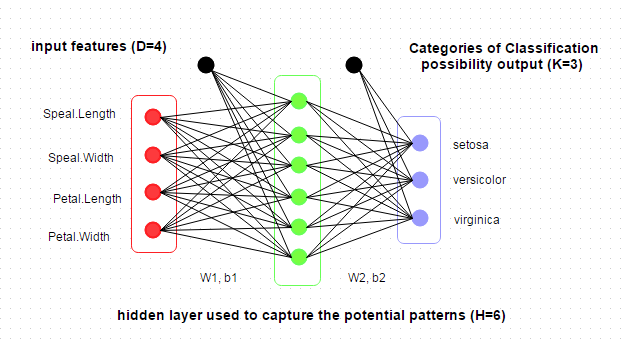



In [ ]:
# defining the model 
class MyModel(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(MyModel, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H, bias=True)
        self.linear2 = torch.nn.Linear(H, D_out, bias=True)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = torch.relu(self.linear1(x))
        y_pred = self.linear2(h_relu)
        return y_pred

### <font color="chillipepper">2. Forward pass</font> 
1. instanciating the model
2. getting input data 
3. computing the foward pass

In [ ]:
# instanciating the model 
N, D_in, H, D_out = 2, 10, 10, 2

# Construct our model by instantiating the class defined above 
# Note: all the parameters are initialized here 
model = MyModel(D_in, H, D_out)
# You can look up into the model 
model

MyModel(
  (linear1): Linear(in_features=10, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)

In [ ]:
# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

In [ ]:
#model = MyModel(D_in, H, D_out)
# forward pass / predict x 
y_pred = model(x) # almost equivalent to model.forward(x)
# y_pred
y_pred

tensor([[0.2433, 0.2901],
        [0.0044, 0.2160]], grad_fn=<AddmmBackward0>)

### 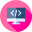
### <font color="chillipepper">Questions</font> 
- Why do the prediction change if the model is re-instanciated ? 
- Can this be a problem ? 
- How to avoid it ? 

**Answers** <br>
If the model is re-instanciated, the prediction change. This happen because each time the model is instanciated, the weigths of the neurons are randomly initialized, thus, they have different value and produce different prediction each time. <br>

This is not a problem because a neural network needs to be trained in order to choose the right parameters (right weights) and this is the task of backward propagation and gradient descent algorithm. <br>

As said previously, by training the neural network the weights will "converge" to a final value and it will give the right predictions according to the training data.



In [ ]:
import torch
# this import contains multiple CLASSES to use (hence you need to instanciate it). Usually different layer types
import torch.nn as nn
# this import contains multiple FUNCTIONS to use (hence no need to instanciate it)
import torch.nn.functional as F


# create the class by inheriting the PyTorch Module
class BiLSTM(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, args, dimension=300, freeze_embeddings = False):
        '''
        construtor of the class (function automatically used when creating a new instance of this class)
        '''
        super(BiLSTM, self).__init__()

        # put args as a class variable
        self.args = args
        # create the embedding layer from the pretrained vectors
        self.embedding = nn.Embedding.from_pretrained(glove_vectors.vectors, freeze=freeze_embeddings)

        # instanciate the SimpleAvgConvEBD class, dedicate to average the utterances
        self.utterance_ebd = SimpleAvgConvEBD(None, {}, avg_global=False)
        # put the SimpleAvgConvEBD instance into the device (cpu or gpu), depending on the arguments
        if self.args['cuda'] != -1: self.utterance_ebd.cuda(args['cuda'])

        # put dimension as a class variable
        self.dimension = dimension

        # instanciate the LSTM class from PyTorch. Dimensions are divided by 2 due to bidirectional being True
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension//2, 
                            num_layers=3,
                            batch_first=True,
                            bidirectional=True)
        # instanciate a dropout layer with 0.5. This means, we will ignore (put to zeros) half (0.5) of the data to prevent the model from overfitting
        self.drop = nn.Dropout(p=0.5)

        # instanciate a linear layer with an output size equal to the number of classes. This means this will be used to apply a criterion to compute the predictions.
        self.hidden2tag = nn.Linear(dimension, num_class)

    def forward(self, data, text_len=12):
        '''
        The forward function. Used to apply the model (during training or inference).
        '''
        # use the function previously defined, in order to put the data values in the GPU is said so in the args
        data = batch_to_cuda(data, self.args['cuda'])
        
        # keep the device in a variable in order to prevent further mistakes
        device = data['text'].device   

        # use the utterance average embeddings to transform the data['text'] into a representation of conversation with a vector per utterance 
    
        text_emb = self.utterance_ebd(data['text'])
        #print(text_emb.size())
        # apply the LSTM and retrieve the output, and the hidden vector. Hidden vector is not used afterwards. It would be useful in case of another type of LSTM for instance
        output, hidden = self.lstm(text_emb)

        # apply the dropout layer (ignore 50% of the data)
        output = self.drop(output)

        # apply the linear layer to have class logits
        outputs = self.hidden2tag(output)

        # keep some dimension infos as variable for convenience
        batch_size = outputs.size(0)
        seq_len = outputs.size(1)

        # modify the outputs representation to prepare score computation
        outputs = outputs.view(batch_size*seq_len, -1)
        # apply a softmax on the outputs to obtain probabilities
        scores = F.log_softmax(outputs, 1)

        # get the predicted tags using the maximum probability from the softmax
        _, tag_seq  = torch.max(scores, 1)
        # reshape the predicted tags to follow the batch and sequence length
        tag_seq = tag_seq.view(batch_size, seq_len)

        # some example of manual class weights
        # weights = torch.Tensor([0.1, 1, 1, 1, 1, 1, 1]).to(device)

        
        if 'class_weights' in self.args:
          # class weights from args if there is any. It should be a torch tensor, but we move it to the dedicated device
          # we use class weights to influence the Negative Log Likelihood. Influencing in the same time the backpropagation and, thus, the update of the model
          loss_fn = nn.NLLLoss(weight=self.args['class_weights'].to(device))  
        else: 
          # if not 'class_weights' key in the args dict(), we use the Negative Log Likelihood as is
          loss_fn = nn.NLLLoss()

        # apply the loss function (Softmax + NLLLoss = Cross Entropy)
        loss = loss_fn(scores, data['label'].view(batch_size*seq_len))

        # we return 3 elements as a tuple : the loss, the softmax outputs, and the predicted tag set already in a good format
        return loss, scores, tag_seq

# <font color="chillipepper">**Training Loop as a function (to incorporate validation)**</font>

### <font color="chillipepper">3. Training loop </font>

- Criterion : 

a model is trained with regard to a _training criterion_ or a _loss_.   
Pytorch provides many different pre-coded losses : 
    - Mean-Square Error 
    - Categorical Cross-Entropy , ...

Most of them can be found in [torch.nn](https://pytorch.org/docs/stable/nn.html) 
- Optimizer 

In pytorch as in any deep learning framework (Tensorflow for instance), models are trained with backpropagation. Backpropagation consists in applying Stochastic Gradient Descent (SGD) to a neural network. There is a broad range of variants around the simple form of SGD. 

Pytorch provides pre-defined objects for many different forms of Gradient Descent algorithm in [torch.optim](https://pytorch.org/docs/stable/optim.html):
- SGD 
- Adadelta 
- Adam 

In this notebook we use the latter, due to its usually faster convergence.

The optimizer will be instanciated with it's configuration (*e.g.* the *step_size* or *learning_rate* for SGD), and the network's parameters.

Overview of all the Gradient Descent based algorithms : https://ruder.io/optimizing-gradient-descent/ 


- Training Loop :
    - forward pass to get prediction and the loss value (what a coincidence we have a `forward()` function in our model! 🙂)
    - zero_grad : Resetting the gradient value to zero for all parameters before adding their newly backpropagated values (this step is crucial!) 
    - compute the gradients' value with `loss.backward()`
    - update all the parameters of the model with `optimizer.step()`

The order of these steps should **NOT** be changed!



In [ ]:
def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    # put parameters of the model and the optimizer to zero before doing another iteration
    optimizer.zero_grad()
    model.zero_grad()

    # apply the model on the batch
    ##print('batcgh ', batch['text'].size())
    loss, logits, tag_seq = model(batch)
    # compute gradient values
    loss.backward()
    # indicate to the optimizer we've done a step
    optimizer.step()
    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


# <font color="chillipepper">**Inference Loop as a function**</font>

In [ ]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """
  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():
      # apply the model
      loss, logits, tag_seq = model(batch)
      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

# <font color="chillipepper">**Start Training 📉**</font>

In [ ]:
import torch.optim as optim

def run_epochs(model, args):

  if args['cuda'] != -1:
      model.cuda(args['cuda'])
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      args['device'] = device
      print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])
  
  val_ep_losses = list()

  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    val_ep_losses.append(val_loss_it_avg)

  return val_ep_losses

Calculate weight classes

In [ ]:
# this scikit learn class calculates class weights given the number of occurrence of each class
from sklearn.utils import class_weight

# first flatten the labels to obtain a 1D numpy array
y = train_data['label'].flatten()
# use the scikit learn to compute weights in order to try to balance the classes
# np.unique(y) is equal to list(set(y.tolist())) but returns a numpy array
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
# let's print the weights for each class by creating a dictionary
print({i:w for i, w in enumerate(class_weights)})
# let's save these weights into the args so our model will use it automatically (because we code it to do so)
args['class_weights'] = torch.Tensor(class_weights.tolist())

{0: 0.1602467552121994, 1: 24.095358497381252, 2: 64.17316017316017, 3: 145.49182115594328, 4: 1.7597108827835446, 5: 20.582536254242516, 6: 12.689366558873882}


In [ ]:
args.update({'max_eps': 3, 'lr': 0.001, 'device': 'cpu', 'cuda': -1, 'seq_len':12, 'num_class': 7})

# Instantiate model with pre-trained glove vectors
model = BiLSTM(pretrained_embeddings, args['num_class'], args, dimension=300, freeze_embeddings = True )
loss_list_val = run_epochs(model, args)

Epoch 0::   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 0/3 : Training : (loss 1.8362982194087003) (acc 0.487091738183148)


validation::   0%|          | 0/31 [00:00<?, ?it/s]

validation : (loss 1.7019714155504782) (acc 0.48689516321305304)


Epoch 1::   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 1/3 : Training : (loss 1.7866705188833671) (acc 0.45427323536415953)


validation::   0%|          | 0/31 [00:00<?, ?it/s]

validation : (loss 1.7197149953534525) (acc 0.43002352118492126)


Epoch 2::   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 2/3 : Training : (loss 1.723903007053848) (acc 0.44433687597255545)


validation::   0%|          | 0/31 [00:00<?, ?it/s]

validation : (loss 1.614618186027773) (acc 0.4191028225806452)


Now let's plot the validation loss.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  # in our model we use Softmax then NLLLoss which means Cross Entropy loss
  plt.ylabel('Cross Entropy')
  # in our training loop we used an Adam optimizer so we indicate it there
  plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'Adam'))
  # let's directly show the plot when calling this function
  plt.show()

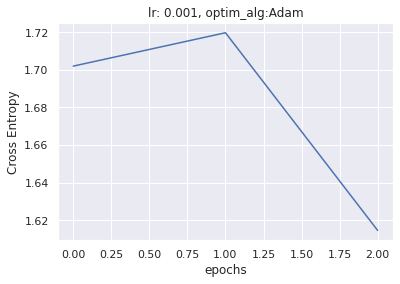

In [ ]:
# let's call our function using the list of validation losses to show the plot
plot_loss(loss_list_val)

# <font color="chillipepper">**Start Testing 📊**</font>

In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, model)

test::   0%|          | 0/31 [00:00<?, ?it/s]

test : (loss 1.7830412657030168) (acc 0.44682459965828925)


In [ ]:
len(preds)

992

It may be quite huge but let's compare the real values and the predicted ones side by side

In [ ]:
for t, p in zip(trues, preds):
  print(t, p)

[0, 0, 5, 1, 5, 1, 0, 1, 0, 0, 0, 0] [0, 0, 5, 6, 6, 4, 6, 5, 6, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4] [0, 0, 0, 5, 6, 5, 6, 5, 6, 4, 6, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 5]
[0, 0, 5, 0, 0, 0, 0, 0, 0, 4, 0, 4] [6, 1, 6, 1, 6, 1, 6, 1, 6, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0] [0, 0, 0, 1, 5, 6, 6, 6, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 5, 6, 5, 6, 5]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 5, 6, 6, 5, 6, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 5, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4] [0, 0, 0, 0, 0, 6, 6, 6, 5, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 6, 6, 4, 6, 4, 6, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 4, 4]
[0, 0, 0, 0, 0, 4, 0, 4, 0, 4, 4, 4] [

Let's print the classification report to have an idea of each class performance and the macro average f1 score

In [ ]:
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))

              precision    recall  f1-score   support

  no emotion       1.00      0.45      0.62     10537
       anger       0.02      0.09      0.04       114
     disgust       0.02      0.09      0.03        43
        fear       0.00      0.00      0.00        17
   happiness       0.21      0.47      0.29       989
     sadness       0.02      0.30      0.03        93
    surprise       0.03      0.66      0.05       111

    accuracy                           0.45     11904
   macro avg       0.18      0.29      0.15     11904
weighted avg       0.90      0.45      0.57     11904



Let's print the confusion matrix. This is the core part to dive into model's performance indications.

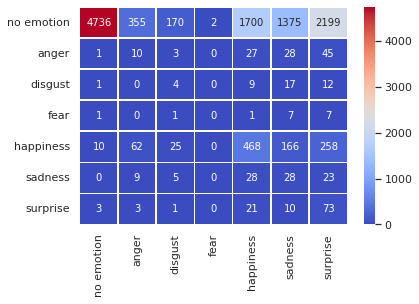

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

# <font color="chillipepper">**Insights on Results 🤔**</font>

Now let's dive into the results.

**Questions:**
- What can you say about the results obtained in the projects ?
- What makes both models (logistic regression and LSTM) different ? How does it influence the results ?
- Propose at least one way to improve this sequence labelling task.

**Answers** <br>
Looking at the confusion matrix, the BiLSTM model has worst predictions than the logistic regression model. It predicted many 'happiness', 'sadness' and 'surprise' labels as 'no emotion'. <br>
<br>
The logistic regression is a classical Machine Learning algorithm, it is a quite simple model offering poor results over the dataset. On the other hand, the BiLSTM is a recurrent neural network, it has a long-short term memory over the words it encountered during the training, but it presented even worse prediction results than the logistic regression. The logistic regression is faster than the LSTM: the main issue with a neural network is the amount of data required in the training phase. <br>
Furthermore, we can see that the BiLSTM overfitted the training data: having a vast majority of 'no emotion' labels, in many cases it confused 'happiness' or 'sadness' labels with 'no emotion' (even though there is a 'dropout layer' to avoid overfitting). <br>
<br>
A point of improvement in the sequence labelling task would be to reduce the amount of 'no emotion' labels. In fact, during the data preprocessing, we adjusted the utterances sizes with 'pad' words and assignated a '0' label. In other words, a solution would be to tackle the unbalanced data representation. By removing these dummy data, maybe the model would overfit less and present better results. <br>
Another point of improvement would be to change the size of embedding : in this case we choose 50 and it is quite few in order to have good results. By taking 300 "features" the model can have better results even if the training would take longer (and by increasing the epoch number too).

**Design a graphic representation of the two models**: the one based on Logistic Regression, and the Deep learning model.

The graphic representation should allow to see the data sizes/shapes, and how it flows into the model(s).

You can use the software you prefer (Powerpoint, Google Slides, etc.). However, I recommend the following one: https://app.diagrams.net/

**Logistic Regression Model Diagram** <br>
<br>
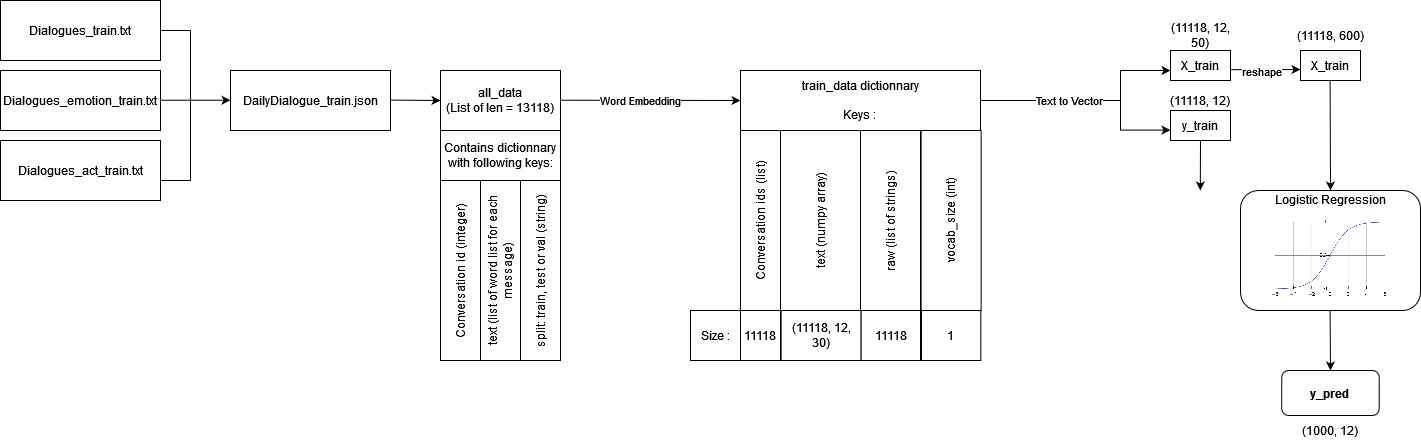

**Deep Learning Model Diagram** <br>
<br>
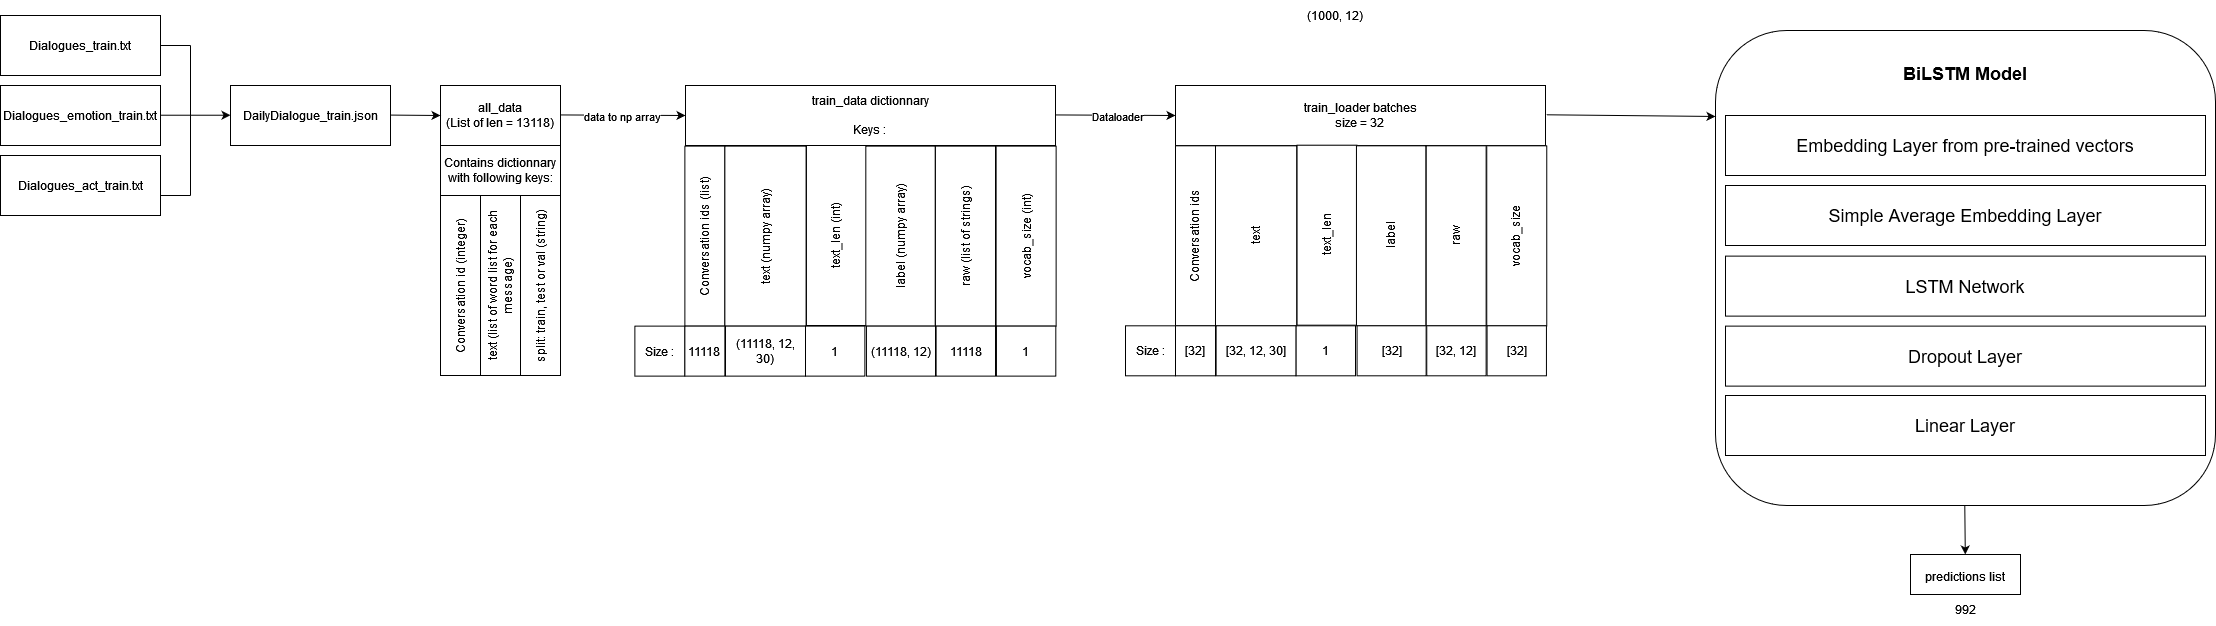

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Creative part I : VADER Sentiment Analysis Tool (Added Part)

The VADER tool allows one to retrieve the polarity of an input text by computing different scores:


*   The positive score "pos" : 
*   The negative score "neg"
*   The neutral score "neu"
*   The "compound" score : by summing all the valence scores and normalized between -1 and 1. If it is greater than 0.05, the text is considered as positive, if it is lower than -0.05 it is considered as negative, otherwise it is neutral.

By studying this tool, we asked ourselves: is it possible to enhance the performances of the logistic regression model by adding a feature giving an information about the polarity of the text ? <br>
What we tried to do, is to add the compound information as a new feature by appending it to the 'text' data and feed it to the logistic regression model. <br>

**New data representation** <br>

Firstly, we created new dictionnary entries in the all_data dataset : compound, positive, negative and neutral scores.

In [ ]:
## UTTERANCE SCALE ##
# Adding new keys to "all_data" : positive, negative and neutral
new_all_data = all_data
# loop over the all_data elements
for el in tqdm(new_all_data):
  # creating new dict entries
  el["compound"] = list()
  el["neg"] = list()
  el["neu"] = list()
  el["pos"] = list()
  #Loop over the texts
  for utt in el['text']:
    # compute the utterances VADER values
    vader_values = sentiment.polarity_scores(' '.join(utt))  # utt is a list of string, so we join them
    # append VDER values
    el["compound"].append(vader_values["compound"])
    el["neg"].append(vader_values["neg"])
    el["neu"].append(vader_values["neu"])
    el["pos"].append(vader_values["pos"])

  0%|          | 0/13118 [00:00<?, ?it/s]

We obtain the following results : each element is the compound score for each utterances of the first dialogue.

In [ ]:
new_all_data[0]['compound']

[0.0,
 0.0,
 0.0,
 -0.2207,
 0.6808,
 0.1179,
 -0.2755,
 0.6705,
 0.6486,
 0.908,
 0.0,
 0.0]

For the following code, we will try to add only the feature "compound score". It seems to be the most relevant feature because it takes into account the positive and negative polarity of the text : it's a global score.

**Change data to numpy array**

In [ ]:
train_data_vader = [d for d in new_all_data if d['split'] == 'train']
val_data_vader = [d for d in new_all_data if d['split'] == 'val']
test_data_vader = [d for d in new_all_data if d['split'] == 'test']

In the X_train, we append the computed feature : the "compound" score

In [ ]:
def text_to_vectors_average_utterance_VADER(data, ebd, dim=301):
  pad_vector = np.ones(dim)
  unk_vector = np.zeros(dim)
  data_vectors = list()
  for d in tqdm(data):
    conversation_vectors = list()
    for i, utterance in enumerate(d['text']):
      utterance_vectors = list()
      for w in utterance:
        try:
          utterance_vectors.append(np.append(ebd[w], d['compound'][i]))
        except:
          utterance_vectors.append(unk_vector)
      avg_utterance_vector = np.mean(np.array(utterance_vectors), axis=0)
      conversation_vectors.append(avg_utterance_vector.tolist())
    data_vectors.append(conversation_vectors)
  return np.array(data_vectors)

In [ ]:
X_train = text_to_vectors_average_utterance_VADER(train_data_vader, pretrained_ebd)
y_train = np.array([ d['label'] for d in train_data_vader ])

X_test = text_to_vectors_average_utterance_VADER(test_data_vader, pretrained_ebd)
y_test = np.array([ d['label'] for d in test_data_vader ])

  0%|          | 0/11118 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
X_train[0][-1]

array([-1.65416648e-02, -9.31233376e-02, -7.05700045e-02,  9.65666523e-03,
       -1.05906650e-02,  2.93596673e-02, -1.78230005e-01, -2.19833354e-02,
        9.54106686e-02, -1.10223337e+00,  2.09533324e-02, -7.45199968e-02,
       -4.61750006e-02,  4.18233325e-02,  5.94100008e-02,  2.88384719e-01,
       -2.21346666e-01,  2.77589992e-01,  4.37999989e-02,  1.35635997e-01,
        1.73800004e-03,  2.37256676e-01,  3.20679992e-01, -2.37113662e-01,
       -2.13579997e-01,  3.89666359e-03, -2.80123337e-02, -1.69022668e-02,
       -1.58049996e-01,  6.39186675e-02,  2.69243320e-02,  1.76163336e-01,
        1.82366669e-02, -7.67943351e-02, -6.86406652e-01, -8.97800028e-02,
        6.22649683e-02, -5.49666087e-03, -1.56240996e-01,  1.67596663e-01,
        1.30753333e-01, -5.77666362e-03, -3.88433312e-02, -1.17013335e-01,
        2.15216664e-02, -7.75533418e-03,  2.63149997e-01,  1.58275329e-01,
        6.47636664e-02,  2.10250005e-01, -8.57899984e-02, -1.26596664e-01,
        1.47489999e-01, -

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11118, 12, 301)
(1000, 12, 301)
(11118, 12)
(1000, 12)


**Reshaping the data**

In [ ]:
X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[-1])

In [ ]:
print(X_train.shape)
print(X_test.shape)

(11118, 3612)
(1000, 3612)


**Applying Logistic Regression to new training data**

In [ ]:
# Fit the LogisticRegression using the MultiOutputClassifier wrapper
clf = MultiOutputClassifier(LogisticRegression(n_jobs=-1))
clf.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(n_jobs=-1))

In [ ]:
# prediction
y_pred = clf.predict(X_test)

In [ ]:
print(y_pred.shape)
print(y_test.shape)

(1000, 12)
(1000, 12)


**Flattening the predictions and true values**

In [ ]:
y_pred_flat = y_pred.flatten()
y_test_flat = y_test.flatten()
print(y_pred_flat.shape)
print(y_test_flat.shape)

(12000,)
(12000,)


**Printing the classification report**

In [ ]:
names = ['no emotion', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
print(classification_report(y_test_flat, y_pred_flat, target_names=names))

              precision    recall  f1-score   support

  no emotion       0.92      0.96      0.94     10628
       anger       0.43      0.18      0.25       114
     disgust       0.62      0.12      0.20        43
        fear       0.00      0.00      0.00        17
   happiness       0.53      0.42      0.47       991
     sadness       0.43      0.10      0.17        96
    surprise       0.34      0.16      0.22       111

    accuracy                           0.89     12000
   macro avg       0.47      0.28      0.32     12000
weighted avg       0.87      0.89      0.88     12000



**Results insights** <br>

The classification report shows interesting insights. The precision is the same for the "no emotion" label, but "anger" and "disgust" have a better precision than the regression model without the compound feature. However, the model is less precise in the labels "sadness" and "surprise". <br>

To sum up, the results seems slightly better with the added feature : the macro average went from 0.43 for the first logistic regression, to 0.49 for the new model.

Now let's have a look at the confusion matrix to have a better overview.

**Confusion Matrix**

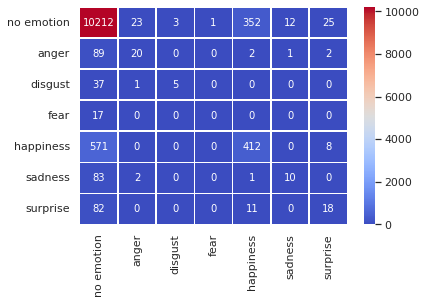

In [ ]:
cm = confusion_matrix(y_test_flat, y_pred_flat)
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

In [ ]:
num_conv = 500
num_utt = 11
print('Input utterance :')
print(all_data[num_conv]['text'][num_utt])
print('Ground Truth Label :', y_test[num_conv][num_utt])
print('Predited Label :', y_pred[num_conv][num_utt])

Input utterance :
['Yes', ',', "I'll", 'be', 'waiting', 'for', 'you', 'in', 'my', 'home', 'by', '10:00', '.']
Ground Truth Labels : 4
Predited Labels : 4


**Conclusion** <br>
The confusion matrix shows that the new model performed better for the labels "happiness", "anger" and "disgust". This can be explained by the fact that these labels are strongly related to "positive" and "negative" polarity. On the other hand, the labels such as "no emotion" or "surprise" can present less polarity than the previous mentioned. <br>
To conclude, by adding a new feature from the VADER tool, we obtained a better precision on some labels.

### Creative part II : SentimentWordNet Analysis Tool (Added Part)

In [ ]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def postag_to_wn(tag):
    """
    Convert pos_tag to compatible sentiwordnet postag
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [ ]:
from tqdm.notebook import trange, tqdm
from termcolor import colored
from nltk.tokenize import TweetTokenizer
import numpy as np
from collections import OrderedDict, Counter, defaultdict

def creaDailyDialogSeq():
  splits = {'train':'dailydialog_train.json', 'test':'dailydialog_test.json', 'val': 'dailydialog_validation.json'}
  splits_emotionflows_fp = { k: os.path.join( os.path.dirname(v), 'dailydialog_{}_emotionflow.json'.format(k) ) for k,v in splits.items() }
  txt2l = { 'no emotion': 0, 'anger': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'sadness': 5, 'surprise': 6 }
  l2txt = { v:k for k, v in txt2l.items() } 
  emotionSet = list(set(list(txt2l.keys())))
  
  emotionFlows = {'train':[],'test':[],'val':[]}

  def getEmotionFlows(row, split):
    row = json.loads(row)
    
    emotionFlow = [ l2txt[r['label']] for r in row ]
    emotionFlows[split].append(emotionFlow)

  for k,v in tqdm(splits.items()):
    for row in tqdm( open(v, 'r').read().split('\n'), desc=colored(v, 'cyan') ) :
      getEmotionFlows(row, k)

  seq_lengths = np.array([ len(x) for x in emotionFlows['train'] ] )
  #  seq_size = np.percentile( seq_lengths, 90)
  #  seq_size = max(seq_lengths)
  seq_size = 12 # we put an arbitrary max length
  print(colored('seq_size', 'yellow'), seq_size, '75%:', np.percentile(seq_lengths, 75), 'max:', max(seq_lengths))
  
  def tokenize_seq(chat):
    # CODE ME!
    tk = TweetTokenizer()
    chat_text = tk.tokenize(chat['raw'])

    #Pos tagging
    after_tagging = nltk.pos_tag(chat_text)
    chat['text'] = chat_text
    #chat['tags'] = after_tagging

    sentiment = 0.0
    #Looping through all tags
    for word, tag in after_tagging:
      wn_tag = postag_to_wn(tag)
      if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
          continue

      synsets = wn.synsets(word, pos=wn_tag)
      if not synsets:
          continue

      # Take the first sense, the most common
      synset = synsets[0]
      swn_synset = swn.senti_synset(synset.name())

      sentiment += swn_synset.pos_score() - swn_synset.neg_score()

    chat['sentiment'] = sentiment
    return chat
  
  def _trimpad(size, row, pad=True, trim=True):
    ''' trim and padding (with <pad>) '''
    # CODE ME!
    # Reshapping all dialogues with same lengh (12 utterances)   
    n = len(row['texts'])
    
    if n < seq_size:
      [row['texts'].insert(0, ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>']) for _ in range(seq_size - n)]
      [row['labels'].insert(0, 0) for _ in range(seq_size - n)]
    elif n > seq_size:
      for j in range(n - seq_size):
        del row['texts'][0]
        del row['labels'][0]
  
    return row
  
  dataSplits = {'train':[], 'test': [], 'val':[]}
  # loop over train, test and validation sets
  for split in dataSplits.keys():
    for i, data in tqdm( enumerate( [ json.loads(line) for line in open(splits[split], 'r').read().split('\n') ]  ), desc=colored('formatting sequence '+split, 'cyan'), total=len(emotionFlows[split]) ):
      data = [ tokenize_seq(chat) for chat in data ]
      #Adding 'tags' attribute and 'sentiments' attribute
      entry = {'texts': [ x['text'] for x in data], 'sentiment': [ x['sentiment'] for x in data], 'labels': [ x['label'] for x in data], 'split': split}
      entry = _trimpad(seq_size, entry)
      dataSplits[split].append(entry)
  labels_train = Counter([ label for line in dataSplits['train'] for label in line['labels'] ])
  labels_val = Counter([ label for line in dataSplits['val'] for label in line['labels'] ])
  labels_test = Counter([ label for line in dataSplits['test'] for label in line['labels'] ])
  print(colored('labels balance', 'yellow'), labels_train, len(labels_train.keys()), labels_val, len(labels_val.keys()), labels_test, len(labels_test.keys()))

  records = dataSplits['train'] + dataSplits['val'] + dataSplits['test']
  jsonLines = [json.dumps(line) for line  in tqdm(records)]
  with open('dailydialog_conv{}seq_splits.json'.format(str(int(seq_size))), 'w') as f: f.write('\n'.join(jsonLines))

In [ ]:
creaDailyDialogSeq()

  0%|          | 0/3 [00:00<?, ?it/s]

dailydialog_train.json:   0%|          | 0/11118 [00:00<?, ?it/s]

dailydialog_test.json:   0%|          | 0/1000 [00:00<?, ?it/s]

dailydialog_validation.json:   0%|          | 0/1000 [00:00<?, ?it/s]

seq_size 12 75%: 10.0 max: 35


formatting sequence train:   0%|          | 0/11118 [00:00<?, ?it/s]

formatting sequence test:   0%|          | 0/1000 [00:00<?, ?it/s]

formatting sequence val:   0%|          | 0/1000 [00:00<?, ?it/s]

labels balance Counter({0: 118938, 4: 10831, 6: 1502, 5: 926, 1: 791, 2: 297, 3: 131}) 7 Counter({0: 11061, 4: 679, 6: 99, 5: 76, 1: 71, 3: 11, 2: 3}) 7 Counter({0: 10628, 4: 991, 1: 114, 6: 111, 5: 96, 2: 43, 3: 17}) 7


  0%|          | 0/13118 [00:00<?, ?it/s]

In [ ]:
def _load_json_seq(path, args):
    '''
        load our json format data file
        @param path: str, path to the data file
        @return data: list of examples
    '''
    label = {}
    text_len = []
    with open(path, 'r', errors='ignore') as f:
        data = []
        for i, line in enumerate(f):
            row = json.loads(line)

            for l in row['labels']:
                if int(l) not in label: label[int(l)] = 1
                else: label[int(l)] += 1

            item = {
                'id': i+1,
                'label': [int(r) for r in row['labels'] ],
                'text': [ r[-args['maxtokens']:] for r in row['texts'] ],
                'sentiment': [ float(r) for r in row['sentiment'] ]
            }

            if 'split' in row: item['split'] = row['split']

            text_len.append(len(row['texts']))

            data.append(item)

        print('Class balance (load_json_seq):')

        print(label)

        print('Avg len: {}'.format(sum(text_len) / (len(text_len))))
        print('Max len: {}'.format(max(text_len)))

        return data

In [ ]:
all_data = _load_json_seq("dailydialog_conv12seq_splits.json", {'maxtokens': 30})

Class balance (load_json_seq):
{0: 140627, 4: 12501, 6: 1712, 3: 159, 2: 343, 5: 1098, 1: 976}
Avg len: 12.0
Max len: 12


In [ ]:
train_data = [d for d in all_data if d['split'] == 'train']
val_data = [d for d in all_data if d['split'] == 'val']
test_data = [d for d in all_data if d['split'] == 'test']

In [ ]:
def text_to_vectors_average_utterance(data, ebd, dim=300):
  pad_vector = np.ones(dim)
  unk_vector = np.zeros(dim)
  data_vectors = list()
  for d in tqdm(data):
    conversation_vectors = list()
    index_sentiment = 0
    for utterance in d['text']:
      utterance_vectors = list()
      for w in utterance:
        try:
          utterance_vectors.append(ebd[w])
        except:
          utterance_vectors.append(unk_vector)
      avg_utterance_vector = np.mean(np.array(utterance_vectors), axis=0)
      #Adding 'sentiment' feature
      if avg_utterance_vector.any() != unk_vector.all():
        avg_utterance_vector = avg_utterance_vector.tolist()
        avg_utterance_vector.append(d['sentiment'][index_sentiment])
        conversation_vectors.append(avg_utterance_vector)
        index_sentiment +=1
      else:
        avg_utterance_vector = avg_utterance_vector.tolist()
        avg_utterance_vector.append(0)
        conversation_vectors.append(avg_utterance_vector)
    data_vectors.append(conversation_vectors)
  return np.array(data_vectors)

In [ ]:
X_train = text_to_vectors_average_utterance(train_data, pretrained_ebd)
y_train = np.array([ d['label'] for d in train_data ])

X_test = text_to_vectors_average_utterance(test_data, pretrained_ebd)
y_test = np.array([ d['label'] for d in test_data ])

  0%|          | 0/11118 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11118, 12, 301)
(11118, 12)
(1000, 12, 301)
(1000, 12)


In [ ]:
X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[-1])

In [ ]:
print('flatten shapes')
print(X_train.shape)
print(X_test.shape)

flatten shapes
(11118, 3612)
(1000, 3612)


In [ ]:
# CODE ME!
# Fit the LogisticRegression using the MultiOutputClassifier wrapper
clf = MultiOutputClassifier(LogisticRegression(n_jobs=-1))
clf.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(n_jobs=-1))

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred_flat = y_pred.flatten()
y_test_flat = y_test.flatten()
print(y_pred_flat.shape)
print(y_test_flat.shape)

(12000,)
(12000,)


In [ ]:
names = ['no emotion', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
print(classification_report(y_test_flat, y_pred_flat, target_names=names))

              precision    recall  f1-score   support

  no emotion       0.92      0.96      0.94     10628
       anger       0.36      0.11      0.17       114
     disgust       0.56      0.12      0.19        43
        fear       0.00      0.00      0.00        17
   happiness       0.52      0.41      0.46       991
     sadness       0.48      0.11      0.18        96
    surprise       0.30      0.14      0.19       111

    accuracy                           0.89     12000
   macro avg       0.45      0.26      0.30     12000
weighted avg       0.87      0.89      0.88     12000



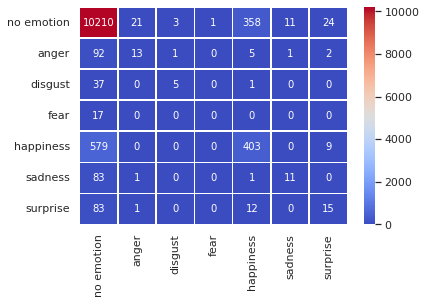

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(y_test_flat, y_pred_flat)
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

## Creative Part III : PCA

In this section, we will try to implement a Principal Component Analysis in order to select the most important features and to diminish the dimension. We will use the PCA function from Sci-Kit Learn library.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
#Kaiser criterion : we should keep 49 p.c
len(pca.explained_variance_[pca.explained_variance_ > np.mean(pca.explained_variance_)])

334

With the Kaiser criterion, the number of principal components retained is 49. Now let's print the eigen values :

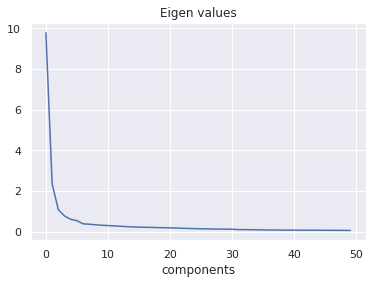

In [ ]:
#Elbow criterion : we should keep max 10 p.c
plt.plot(pca.explained_variance_[:50])
plt.title("Eigen values")
plt.xlabel('components')
plt.show()

In [ ]:
pca = PCA(n_components = 49)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
clf = MultiOutputClassifier(LogisticRegression(n_jobs=-1))
clf.fit(X_train_pca, y_train)

MultiOutputClassifier(estimator=LogisticRegression(n_jobs=-1))

In [ ]:
y_pred = clf.predict(X_test_pca)
y_pred_flat = y_pred.flatten()
y_test_flat = y_test.flatten()

In [ ]:
names = ['no emotion', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
print(classification_report(y_test_flat, y_pred_flat, target_names=names))

              precision    recall  f1-score   support

  no emotion       0.90      0.99      0.94     10628
       anger       0.00      0.00      0.00       114
     disgust       1.00      0.02      0.05        43
        fear       0.00      0.00      0.00        17
   happiness       0.57      0.19      0.28       991
     sadness       0.00      0.00      0.00        96
    surprise       0.00      0.00      0.00       111

    accuracy                           0.89     12000
   macro avg       0.35      0.17      0.18     12000
weighted avg       0.85      0.89      0.86     12000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Unfortunately, the PCA showed very poor results compared to the normal logistic regression.

## Resources

### VADER Sentiment Analysis

https://github.com/cjhutto/vaderSentiment

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()
a = sentiment.polarity_scores("NLP is the best branch of Artificial intelligence !")
a

{'compound': 0.8221, 'neg': 0.0, 'neu': 0.441, 'pos': 0.559}

### SentiWordNet

Documentation from NLTK: https://www.nltk.org/howto/sentiwordnet.html

In [ ]:
import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
from nltk.corpus import sentiwordnet as swn

In [ ]:
list(swn.senti_synsets('telecom'))

[SentiSynset('telecommunication.n.01')]

In [ ]:
for synset in list(swn.all_senti_synsets())[:5]:
  print(synset)

<able.a.01: PosScore=0.125 NegScore=0.0>
<unable.a.01: PosScore=0.0 NegScore=0.75>
<abaxial.a.01: PosScore=0.0 NegScore=0.0>
<adaxial.a.01: PosScore=0.0 NegScore=0.0>
<acroscopic.a.01: PosScore=0.0 NegScore=0.0>
